In [96]:
import package_root
import os

data_path = os.path.join(package_root._find_root(), 'data')

### load data

In [97]:
import pal.problem.sdd as csdd
import pal.distribution.spline_distribution as spline
from pal.wmi.compute_integral import integrate_distribution

In [98]:
sdd = csdd.SDDSingleImageTrajectory(
    img_id=12,
    path=os.path.join(data_path, 'sdd'),
)

### load model

In [99]:
import torch

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

model_state = torch.load(os.path.join(data_path, 'sdd_spline_example.pth'),map_location=device)

In [100]:
from pal.training.train_mlp_sdd import get_spline_model

spline_model = get_spline_model(
    sdd=sdd,
    num_knots=14,
    num_mixtures=8,
    net_size="large",
    init_last_layer_positive=True,
    device=device,
)

spline_model.load_state_dict(model_state)

Time to integrate distribution: 14.97 seconds


<All keys matched successfully>

### plot prediction

In [101]:
import analysis.plot_helper as plot_helper
# reload plot_helper
import importlib
importlib.reload(plot_helper)

mesh, mesh_grid, img_extent, valid = plot_helper.prepare_meshgrid(problem=sdd, resolution=500)

border = plot_helper.prepare_border(problem=sdd, meshgrid=mesh_grid)

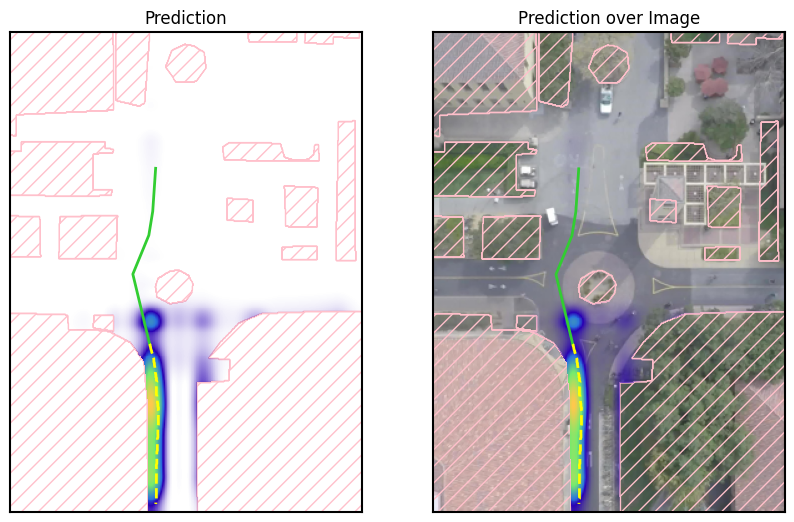

In [120]:
import matplotlib.pyplot as plt

test_dataset = sdd.load_dataset().test

test_idx = 26891

# returns the full future for the remaining trajectory
_, _, test_full_horizon = sdd.dataset.get_trajectories_prediction_full_horizon()

x,y_future = test_full_horizon[test_idx]

with torch.no_grad():
    x_t = torch.tensor(x, dtype=torch.float32).reshape(-1)
    distribution = spline_model(x_t.unsqueeze(0).to(device))
    densities = distribution.log_dens(mesh.to(device), with_indicator=True).exp().cpu().numpy()
    densities = densities.reshape(mesh_grid[0].shape).T

plt_extent = [0, img_extent[1], img_extent[3], 0]


fig, axs = plt.subplots(1, 2, figsize=(10, 10))
ax = axs[0]
plot_helper.plot_diverging(
    the_ax=ax,
    data=densities,
    valid=valid,
    border=border.T,
    img_extent=plt_extent,
    with_contour=True,
    with_valid=False,
    hatched=True,
    plot_borders_below=True,
    the_cmap=plot_helper.blue_red8_transparent,
)

scale = sdd.dataset.get_scale()

ax.plot(x[:,0], x[:,1], color="limegreen", linewidth=2.0)
ax.plot(y_future[:,0], y_future[:,1], color='yellow', linestyle='--', label='Test Y', linewidth=2.0)

ax.set_title(f"Prediction")

ax = axs[1]
ax.imshow(sdd.dataset.image)

plt_extent = [0, sdd.dataset.image.shape[1], sdd.dataset.image.shape[0], 0]

plot_helper.plot_diverging(
    the_ax=ax,
    data=densities,
    valid=valid,
    border=border.T,
    img_extent=plt_extent,
    with_contour=True,
    with_valid=False,
    hatched=True,
    plot_borders_below=True,
    the_cmap=plot_helper.blue_red8_transparent,
)

ax.set_title(f"Prediction over Image")
# add a black border to the image
# frame a bit thicker
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

ax.plot(x[:,0] / sdd.dataset.scale, x[:,1] / sdd.dataset.scale, color="limegreen", linewidth=2.0)
ax.plot(y_future[:,0] / sdd.dataset.scale, y_future[:,1] / sdd.dataset.scale, color='yellow', linestyle='--', label='Test Y', linewidth=2.0)

plt.savefig(
    os.path.join(data_path, "sdd_spline_example.png"),
    bbox_inches='tight',
    dpi=300,
)

plt.show()